In [46]:
from sklearn.ensemble import RandomForestClassifier as rf
from kdg.utils import generate_gaussian_parity, plot_2dsim
from tqdm import tqdm
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.pyplot import colorbar
from scipy.interpolate import interp2d, Rbf

In [15]:
X, y = generate_gaussian_parity(1000, cluster_std = 0.35)
X_ood, y_ood = generate_gaussian_parity(1000, angle_params=np.pi/4, cluster_std=0.35)

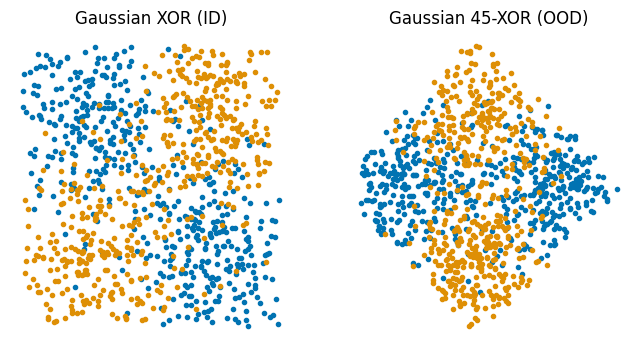

In [17]:
fig, ax = plt.subplots(1,2,figsize=(8,4))

plot_2dsim(X,y, ax=ax[0])
plot_2dsim(X_ood,y_ood, ax=ax[1])

right_side = ax[0].spines["right"]
right_side.set_visible(False)
top_side = ax[0].spines["top"]
top_side.set_visible(False)
left_side = ax[0].spines["left"]
left_side.set_visible(False)
bottom_side = ax[0].spines["bottom"]
bottom_side.set_visible(False)


right_side = ax[1].spines["right"]
right_side.set_visible(False)
top_side = ax[1].spines["top"]
top_side.set_visible(False)
left_side = ax[1].spines["left"]
left_side.set_visible(False)
bottom_side = ax[1].spines["bottom"]
bottom_side.set_visible(False)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[0].set_title('Gaussian XOR (ID)')
ax[1].set_title(r'Gaussian 45-XOR (OOD)')

plt.savefig('simulation.pdf')

In [18]:
n_estimators = 100
n_seeds = 100
splitting_criteria = ['gini', 'entropy', 'log_loss']
n_criteria = len(splitting_criteria)
n_train_id = 1000
n_test_id = 1000
n_eval_ood = 1000
n_test_ood = 1000
angles = [0, np.pi/8, np.pi/4, np.pi/2]

In [25]:
def experiment(angle, n_components, stress=False, cluster_std = 0.25):
    rf_models = [[] for _ in range(n_criteria)]

    x_train_id, y_train_id = generate_gaussian_parity(n_train_id, cluster_std = cluster_std)
    x_test_id, y_test_id = generate_gaussian_parity(n_test_id, cluster_std = cluster_std)
    
    x_eval_ood, y_eval_ood = generate_gaussian_parity(n_eval_ood, angle_params=angle, cluster_std = cluster_std)
    x_test_ood, y_test_ood = generate_gaussian_parity(n_test_ood, angle_params=angle, cluster_std = cluster_std)
    
    for i in range(n_criteria):
        for j in range(n_seeds):
            model = rf(n_estimators=n_estimators, criterion=splitting_criteria[i], random_state=(j+1)*(i+1))
            model.fit(x_train_id, y_train_id)
            rf_models[i].append(model)

    ##########################################################
    l_id = np.zeros((n_criteria, n_seeds), dtype=float)
    l_ood = np.zeros((n_criteria, n_seeds), dtype=float)
    proba = []
    
    for i in (range(n_criteria)):
        for j in range(n_seeds):
            proba.append(
                rf_models[i][j].predict_proba(x_eval_ood)
            )
            y_pred_id = rf_models[i][j].predict(x_test_id)
            y_pred_ood = rf_models[i][j].predict(x_test_ood)
            l_id[i,j] = 1 - np.mean(y_test_id==y_pred_id)
            l_ood[i,j] = 1 - np.mean(y_test_ood==y_pred_ood)

    ########################################################
    D = np.zeros((n_seeds*n_criteria, n_seeds*n_criteria), dtype=float)

    for ii in range(n_seeds*n_criteria):
        for jj in range(ii+1, n_seeds*n_criteria):
            D[ii,jj] = np.sum((proba[ii]-proba[jj])**2)**.5
            D[jj,ii] = D[ii,jj]

    #######################################################

    embedding = MDS(n_components=n_components, dissimilarity='precomputed')
    X_transformed = embedding.fit_transform(D)

    if stress:
        return X_transformed, l_id, l_ood, embedding.stress_
    else:
        return X_transformed, l_id, l_ood

In [26]:
def plot_embeddings(X_transformed, l_id, l_ood, angle, ax):
    ax.scatter(X_transformed[:100,0], X_transformed[:100,1], l_ood[0], c='k', marker='o', alpha=(l_id[0]-np.min(l_id[0]))/(np.max(l_id[0])-np.min(l_id[0])), label=splitting_criteria[0], s=40)
    ax.scatter(X_transformed[100:200,0], X_transformed[100:200,1], l_ood[1], c='r', marker='o', alpha=(l_id[1]-np.min(l_id[1]))/(np.max(l_id[1])-np.min(l_id[1])), label=splitting_criteria[1], s=40)
    ax.scatter(X_transformed[200:,0], X_transformed[200:,1], l_ood[2], c='b', marker='o', alpha=(l_id[2]-np.min(l_id[2]))/(np.max(l_id[2])-np.min(l_id[2])), label=splitting_criteria[2], s=40)

    ax.set_zlabel('l_ood')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.zaxis.set_major_formatter('{x:.02f}')
    ax.set_title('angle ' + str(np.round(angle*180/np.pi,1)))
    ax.set_xticks([-0.5,0,0.5])
    ax.set_yticks([-0.5,0,0.5])
    

In [27]:
X_transformed, l_id, l_ood = [], [], []
for angle in tqdm(angles):
    X_, l_id_, l_ood_ = experiment(angle, 2)
    X_transformed.append(X_)
    l_id.append(l_id_)
    l_ood.append(l_ood_)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:12<00:00, 33.10s/it]


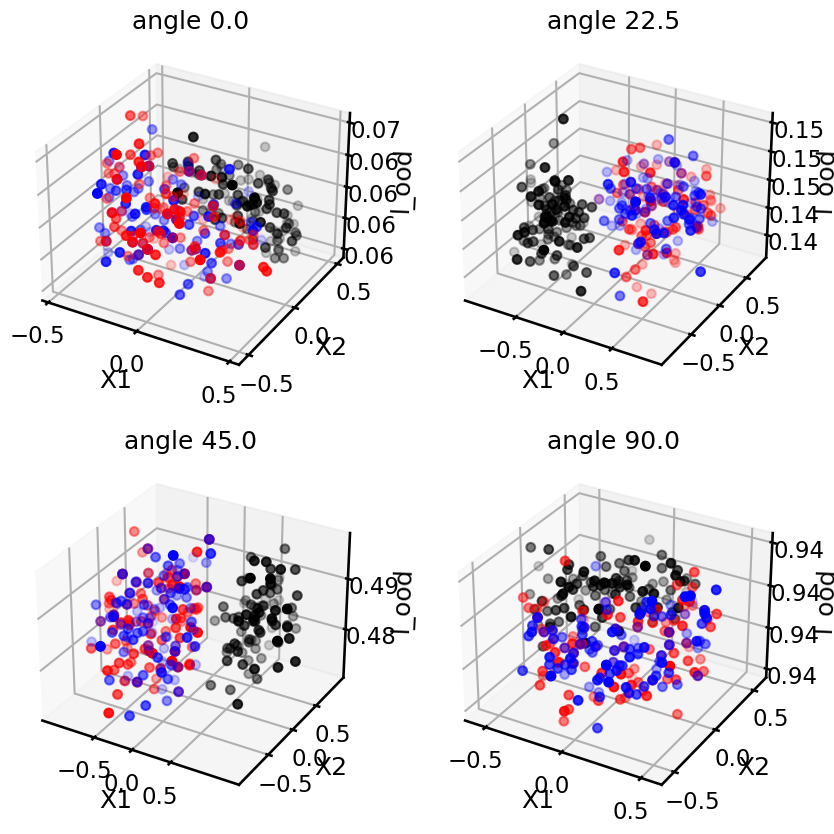

In [45]:
fig = plt.figure(figsize=(10,10))
sns.set_context('talk')

for ii, angle in enumerate(angles):
    ax = fig.add_subplot(2,2,ii+1, projection='3d')
    plot_embeddings(X_transformed[ii], l_id[ii], l_ood[ii], angle, ax)

plt.savefig('embeddings.pdf')

In [549]:
n_components = [1,2,3,4,5,6,7,8,9,10]
stresses = []

for component in tqdm(n_components):
    _, _, _, stress = experiment(np.pi/4, component, stress=True)
    stresses.append(stress)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:30<00:00, 15.07s/it]


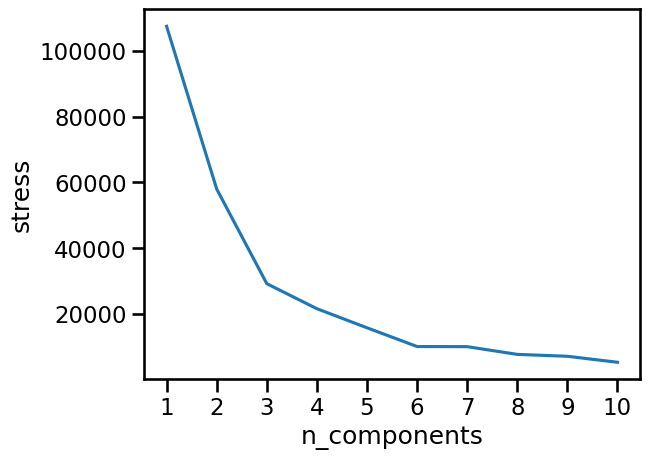

In [550]:
sns.set_context('talk')

plt.plot(n_components, stresses)
plt.xticks(n_components)
plt.xlabel('n_components')
plt.ylabel('stress')
plt.savefig('scree_plot.pdf', bbox_inches='tight')

In [230]:
import pickle

summary = (X_transformed, l_id, l_ood, stresses)

with open('result.pickle','wb') as f:
    pickle.dump(summary, f)

In [38]:
import pickle
with open('result.pickle','rb') as f:
    (X_transformed, l_id, l_ood, stresses) = pickle.load(f)


In [61]:
def plot_embeddings_(X_transformed, l_id, l_ood, angle, ax):
    cmap1 = cm.Blues
    cmap2 = cm.Reds
    cmap3 = cm.Greens
    l_id[0,:] = (l_id[0,:] - np.min(l_id[0,:]))/(np.max(l_id[0,:]) - np.min(l_id[0,:]))
    l_id[1,:] = (l_id[1,:] - np.min(l_id[1,:]))/(np.max(l_id[1,:]) - np.min(l_id[1,:]))
    l_id[2,:] = (l_id[2,:] - np.min(l_id[2,:]))/(np.max(l_id[2,:]) - np.min(l_id[2,:]))

    min_x1, max_x1 = np.min(X_transformed[:100,0]), np.max(X_transformed[:100,0])
    min_x2, max_x2 = np.min(X_transformed[:100,1]), np.max(X_transformed[:100,1])
    X1_grid1 = np.linspace(min_x1, max_x1, 100)
    X2_grid1 = np.linspace(min_x2, max_x2, 100)
    #X1_grid, X2_grid = np.meshgrid(X1_grid, X2_grid)
    X1_grid1, X2_grid1 = np.meshgrid(X1_grid1, X2_grid1)
    
    f = Rbf(X_transformed[:100,0], X_transformed[:100,1], l_ood[0,:], kernel='linear', smoothing=5)
    Z1 = f(X1_grid1, X2_grid1)
    #print(Z1.shape)
    mean_val = np.mean(l_ood[0,:])
    var_val = np.var(l_ood[0,:])**.5
    
    for ii in range(100):
        for jj in range(100):
            if Z1[ii,jj] < mean_val - var_val*10 or Z1[ii,jj]>mean_val + var_val*10:
                Z1[ii,jj] = np.nan


    f = Rbf(X_transformed[:100,0], X_transformed[:100,1], l_id[0,:], kernel='linear', smoothing=5)
    l_id1 = f(X1_grid1, X2_grid1)
    mean_val = np.mean(l_id[0,:])
    var_val = np.var(l_id[0,:])**.5
    
    for ii in range(100):
        for jj in range(100):
            if l_id1[ii,jj] < mean_val - var_val*10 or l_id1[ii,jj]>mean_val + var_val*10:
                l_id1[ii,jj] = np.nan
    
    
    #####################################################################
    min_x1, max_x1 = np.min(X_transformed[100:200,0]), np.max(X_transformed[100:200,0])
    min_x2, max_x2 = np.min(X_transformed[100:200,1]), np.max(X_transformed[100:200,1])
    X1_grid2 = np.linspace(min_x1, max_x1, 100)
    X2_grid2 = np.linspace(min_x2, max_x2, 100)
    X1_grid2, X2_grid2 = np.meshgrid(X1_grid2, X2_grid2)
    
    f = Rbf(X_transformed[100:200,0], X_transformed[100:200,1], l_ood[1,:], kernel='linear', smoothing=5)
    Z2 = f(X1_grid2, X2_grid2)
    
    mean_val = np.mean(l_ood[1,:])
    var_val = np.var(l_ood[1,:])**.5
    
    for ii in range(100):
        for jj in range(100):
            if Z2[ii,jj] < mean_val - 10*var_val or Z2[ii,jj]>mean_val + 10*var_val:
                Z2[ii,jj] = np.nan

    f = Rbf(X_transformed[100:200,0], X_transformed[100:200,1], l_id[1,:], kernel='linear', smoothing=5)
    l_id2 = f(X1_grid2, X2_grid2)
    mean_val = np.mean(l_id[1,:])
    var_val = np.var(l_id[1,:])**.5
    
    for ii in range(100):
        for jj in range(100):
            if l_id2[ii,jj] < mean_val - var_val*10 or l_id2[ii,jj]>mean_val + var_val*10:
                l_id2[ii,jj] = np.nan

    #X1_grid, X2_grid = np.meshgrid(X1_grid2, X2_grid2)
    #####################################################################
    min_x1, max_x1 = np.min(X_transformed[200:,0]), np.max(X_transformed[200:,0])
    min_x2, max_x2 = np.min(X_transformed[200:,1]), np.max(X_transformed[200:,1])
    X1_grid3 = np.linspace(min_x1, max_x1, 100)
    X2_grid3 = np.linspace(min_x2, max_x2, 100)
    X1_grid3, X2_grid3 = np.meshgrid(X1_grid3, X2_grid3)
    
    f = Rbf(X_transformed[200:,0], X_transformed[200:,1], l_ood[2,:], kernel='linear', smoothing=5)
    Z3 = f(X1_grid3, X2_grid3)
    
    mean_val = np.mean(l_ood[2,:])
    var_val = np.var(l_ood[2,:])**.5

    zlim = mean_val
    for ii in range(100):
        for jj in range(100):
            if Z3[ii,jj] < mean_val - 10*var_val or Z3[ii,jj]>mean_val + 10*var_val:
                Z3[ii,jj] = np.nan



    f = Rbf(X_transformed[200:,0], X_transformed[200:,1], l_id[2,:], kernel='linear', smoothing=5)
    l_id3 = f(X1_grid3, X2_grid3)
    mean_val = np.mean(l_id[2,:])
    var_val = np.var(l_id[2,:])**.5
    
    for ii in range(100):
        for jj in range(100):
            if l_id3[ii,jj] < mean_val - var_val*10 or l_id3[ii,jj]>mean_val + var_val*10:
                l_id3[ii,jj] = np.nan


    
    ax.plot_surface(X1_grid1, X2_grid1, Z1,
                           linewidth=0, antialiased=False, facecolors=cmap1(l_id1))
    ax.plot_surface(X1_grid2, X2_grid2, Z2,
                           linewidth=0, antialiased=False, facecolors=cmap2(l_id2))
    ax.plot_surface(X1_grid3, X2_grid3, Z3,
                           linewidth=0, antialiased=False, facecolors=cmap3(l_id3))

    ax.set_zlim([zlim-.1,zlim+.1])
    ax.set_zlabel('l_ood')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.zaxis.set_major_formatter('{x:.02f}')
    ax.set_title('angle ' + str(np.round(angle*180/np.pi,1)))
    ax.set_xticks([-0.5,0,0.5])
    ax.set_yticks([-0.5,0,0.5])

    #ax.view_init(-140, 60) 
    
    return ax

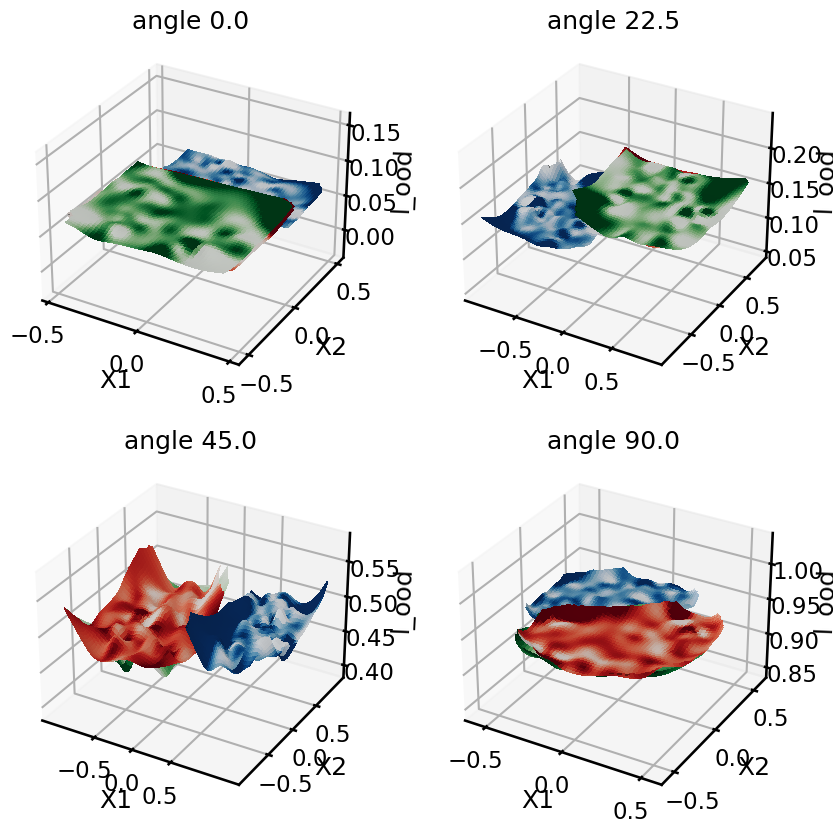

In [62]:
fig = plt.figure(figsize=(10,10), facecolor='white')
sns.set_context('talk')

for ii, angle in enumerate(angles):
    ax = fig.add_subplot(2,2,ii+1, projection='3d')
    surf = plot_embeddings_(X_transformed[ii], l_id[ii], l_ood[ii], angle, ax)
plt.savefig('embeddings_.pdf')

In [449]:
from scipy.interpolate import interp2d

In [453]:
f = interp2d(X_transformed[0][:100,0], X_transformed[0][:100,1], l_ood[0][0,:100])

In [477]:
f(.3,.2)

array([0.06298062])

In [478]:
f([.3,.4],[.2,.5])

array([[0.06298062, 0.06201355],
       [0.00211616, 0.        ]])

In [459]:
np.max(X_transformed[0][:100,0])

0.48141760276706874

In [537]:
surf

<Axes3DSubplot: title={'center': 'angle 90.0'}, xlabel='X1', ylabel='X2', zlabel='l_ood'>

In [462]:
a = np.zeros((2,3))

In [463]:
b = np.ones(a.shape)

In [464]:
b

array([[1., 1., 1.],
       [1., 1., 1.]])

In [467]:
X.ravel()

array([-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75])

In [468]:
Y.ravel()

array([-5.  , -5.  , -5.  , ...,  4.75,  4.75,  4.75])

In [515]:
X

array([[-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       ...,
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75]])

In [516]:
Y

array([[-5.  , -5.  , -5.  , ..., -5.  , -5.  , -5.  ],
       [-4.75, -4.75, -4.75, ..., -4.75, -4.75, -4.75],
       [-4.5 , -4.5 , -4.5 , ..., -4.5 , -4.5 , -4.5 ],
       ...,
       [ 4.25,  4.25,  4.25, ...,  4.25,  4.25,  4.25],
       [ 4.5 ,  4.5 ,  4.5 , ...,  4.5 ,  4.5 ,  4.5 ],
       [ 4.75,  4.75,  4.75, ...,  4.75,  4.75,  4.75]])